## This notebook contains examples for building a 2D probe and computing the scalar pressure field for single-frequency (narrow band) and pulsed (broad band) transmits

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

#display options for the notebook
import matplotlib as mpl


%matplotlib inline

mpl.rcParams['image.cmap'] = 'magma'
mpl.rcParams['image.interpolation'] = 'none'
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = [8.0, 6.0]


In [ ]:
#Setup pyRayleighCuda paths
#Add path to transducers.py and GPU build
sys.path.insert(0,'../') 
sys.path.append('../../../HiFU/code/CUDA/RSgpu/Release')
import transducers
import geom

## Create linear probe

In [2]:
pitch = 0.2 #mm

#transducer element positions
NN = 128 #number of elements
ux = np.linspace(-NN/2, NN/2, NN)*pitch

uxyz = np.zeros([NN,3])
uxyz[:,0] = ux

#element normals are z-directed
unormals = np.zeros([NN,3])
unormals[:,2] = 1

## Define simulation grid

In [3]:
#simulation grid
dx = 0.1
dz = 0.1
xp = np.arange(-16, 16+dx, dx)
yp = [0.0]
zp = np.arange(1.0, 30.0+dz, dz)

Nx,Ny,Nz = (len(xp), len(yp), len(zp))

imgBounds = [zp[0],zp[-1], xp[-1],xp[0]] 
imgBoundsT= np.flipud(imgBounds)
len(zp), len(xp)

(291, 321)

# Narrow-band (single-frequency) transmit

### Calculates $P(\omega) \propto \sum \limits_{n} \frac{e^{i k |\bf{r - u}_n| }}{|\bf{r - u}_n|}$, for $k = \omega / c$

#### Plane wave, narrow band 

In [4]:
c0 = 1480
f0 = 3e6
kr_mm = (2*np.pi*f0/c0)*1e-3 #wavenumber in millimeters

uamp = np.ones([NN], dtype=np.complex)

pr = transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)

pr = pr.squeeze() #remove the singleton y dimension

#### Plot the results:

A narrow-band transmit is equivalent to continous wave so the magnitude of computed of pressure gives a scalar field representing the beam's spatial envelope.

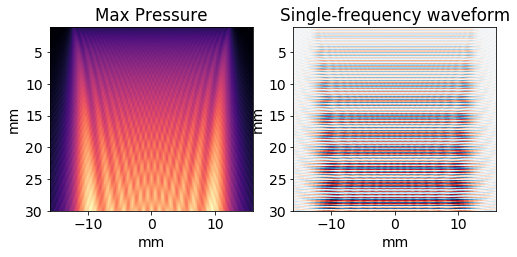

In [5]:

plt.subplot(121)
plt.imshow(np.abs(pr).T, extent=imgBoundsT )
plt.xlabel('mm')
plt.ylabel('mm')
plt.title('Max Pressure')

plt.subplot(122)
plt.imshow(np.real(pr).T, extent=imgBoundsT, cmap=plt.cm.RdBu )
plt.title('Single-frequency waveform')
plt.xlabel('mm')
plt.ylabel('mm')

#### Focused transmit, narrow band

In [6]:
foci_xyz = [[10.0, 0.0, 20.0]]
uamp = transducers.get_focused_element_vals(kr_mm, uxyz, foci_xyz, [1])

pr = transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)

pr = pr.squeeze() #remove the singleton y dimension

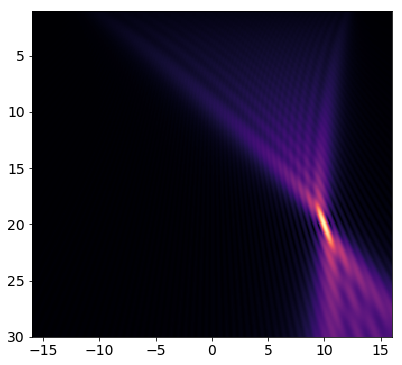

In [7]:
plt.imshow(np.abs(pr).T, extent=imgBoundsT )

#### Multi-focus transmit, narrow band

In [16]:
foci_xyz = [[3.0, 0.0, 20.0], [-3.0, 0.0, 20.0]]
foci_val = np.ones(len(foci_xyz))
uamp = transducers.get_focused_element_vals(kr_mm, uxyz, foci_xyz, foci_val)

pr = transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)

pr = pr.squeeze() #remove the singleton y dimension

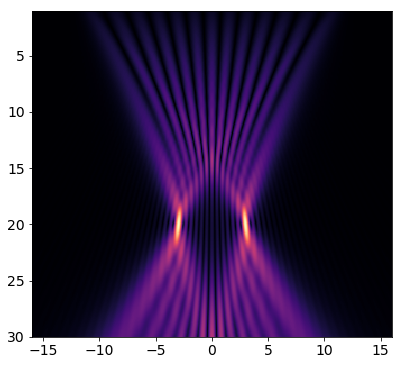

In [17]:
plt.imshow(np.abs(pr).T, extent=imgBoundsT )

#### Alternating phase of foci

In [18]:
uamp = transducers.get_focused_element_vals(kr_mm, uxyz, foci_xyz, foci_val, AlternatePhases=True)

pr = transducers.calc_pressure_field(kr_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)

pr = pr.squeeze() #remove the singleton y dimension

(25, 15)

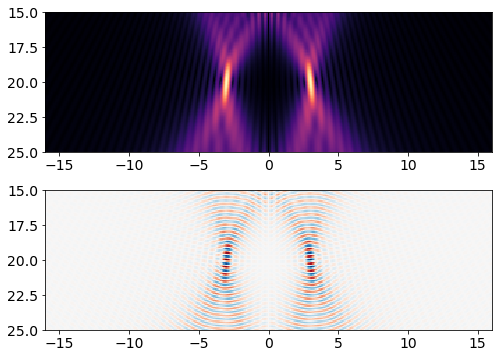

In [19]:
#plt.figure(figsize=(8,4))
plt.subplot(211)
plt.imshow(np.abs(pr).T, extent=imgBoundsT )
plt.ylim([25,15])
plt.subplot(212)
plt.imshow(np.real(pr).T, extent=imgBoundsT, cmap=plt.cm.RdBu )
#plt.xlim()
plt.ylim([25,15])

# Broad-band transmit

Broad-band transmits are more difficult since pressure is computed in the Fourier domain. Below is an example using the spectrum of a gaussian pulse to build a broad-band transmit from a series of single-frequency transmits, whose amplitudes are weighted by the input pulse spectrum. This could be useful to examine the spatial distribution of total energy delivered by a single pulse as it passed through the volume using Parseval's theorem: $I(\mathbf{x}) = \int |p(\mathbf{x}, t)|^2 dt = \int |P(\mathbf{x}, \omega)|^2 d\omega$.

A waveform can be simulated as well by taking the inverse FFT on the stack of complex pressures fields.

** Due to the large number of simulations needed for sufficient spectral sampling, CUDA enabled versions are used here. **

** If the CUDA library hasn't been built, just delete the `_cuda` tag on simulation functions below (and beware longer run-time). **

In [9]:
import scipy.signal as sig

In [316]:
fc = 3e6

Fs = 80e6
dt=1/Fs
t_us = np.arange(0.0, 2.0, dt*1e6)
Nt = len(t_us)
mid = round(Nt/2)

w = sig.gausspulse(t_us - t_us[mid], fc=fc*1e-6, bw=0.5)
wfft = np.fft.fft(w)
freqs = np.fft.fftfreq(Nt,d=dt)

df = freqs[1]-freqs[0]

#wfft = np.fft.fftshift(wfft)
#freqs = np.fft.fftshift(freqs)

C:\Users\Vandiver\Anaconda3\envs\py35\lib\site-packages\scipy\signal\waveforms.py:236: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if t == 'cutoff':  # compute cut_off point


In [317]:
#Build broad-band transmit by interpolating several encodings around the center frequency
#mid=-1
spec_fr = freqs[0:mid]
spec_envelope = np.abs(wfft[0:mid])

stepHz =40e3
sampling_freqs = np.arange(0,20e6, stepHz)
nf = len(sampling_freqs)

sampling_envelope = np.zeros(nf)
threshold = 10**(-30/10)

for i in range(nf):
    fi = sampling_freqs[i]
    sampling_envelope[i] = np.interp(fi, spec_fr, spec_envelope, left=0, right=0.0 )
    
subThreshold = ( np.abs(sampling_envelope) / np.abs(spec_envelope.max())) < threshold

nf

500

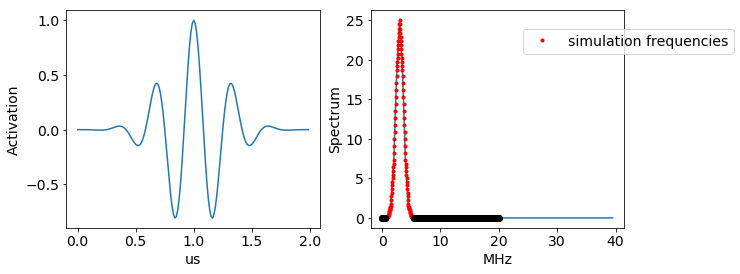

In [318]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(t_us,w)
plt.xlabel('us')
plt.ylabel('Activation')


plt.subplot(122)

plt.plot(freqs[0:mid]*1e-6, np.abs(wfft[0:mid]),'-')
plt.plot(sampling_freqs*1e-6, sampling_envelope, 'r.', label='simulation frequencies')
plt.plot(sampling_freqs[subThreshold]*1e-6, sampling_envelope[subThreshold], 'ko')
plt.xlabel('MHz')
plt.ylabel('Spectrum')
plt.legend(loc=(.6,0.8))

In [315]:

pr = np.zeros([nf,Nx,Ny,Nz],dtype=np.complex)

for i in range(nf):
    
    if subThreshold[i]:
        #If the signal is power is small at this frequency, skip it
        continue
    
    uamp = np.ones(NN)*sampling_envelope[i]
    ki_mm = (2*np.pi*sampling_freqs[i]/c0)*1e-3  #wavenumber corresponding to this frequency
    
    
    pr[i] = transducers.calc_pressure_field_cuda(ki_mm, uxyz, uamp, xp, yp, zp, unormals=unormals)
    
pr = pr.squeeze()

In [419]:
#Inverse fft to get time-resolved pulse


pr_vs_t = np.fft.ifft( pr, axis=0)
t_axis_us = 1e6*np.linspace(0.0, 1.0, len(sampling_freqs)) / stepHz

pr_vs_t.shape

(500, 321, 291)

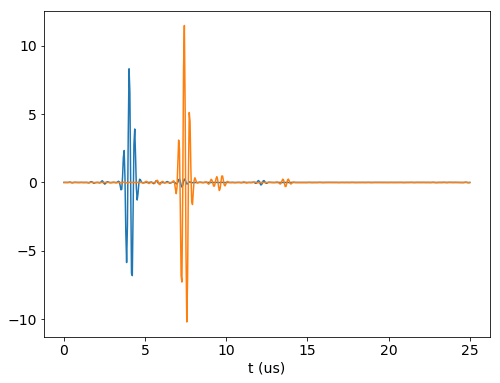

In [420]:
plt.plot(t_axis_us, pr_vs_t[:,200,50].real)
plt.plot(t_axis_us, pr_vs_t[:,200,100].real)
plt.xlabel('t (us)')

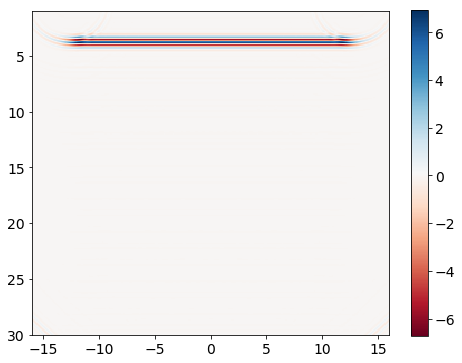

In [374]:
plt.imshow(np.real(pr_vs_t[50]).T, extent=imgBoundsT, cmap=plt.cm.RdBu )
plt.colorbar()

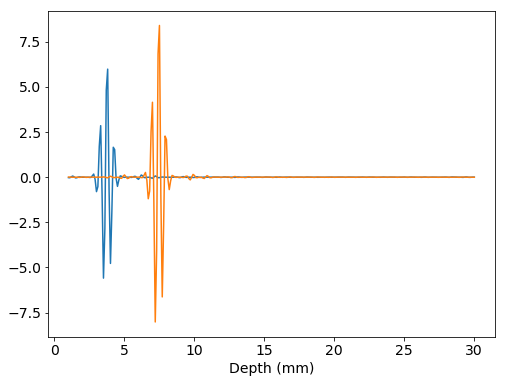

In [369]:
plt.plot(zp, pr_vs_t[50,200,:].real)
plt.plot(zp, pr_vs_t[100,200,:].real)
plt.xlabel('Depth (mm)')

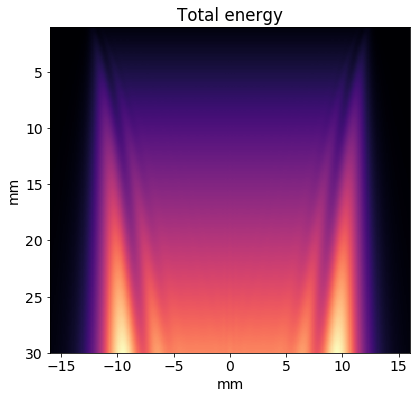

In [370]:
plt.imshow(np.sum( np.abs(pr[0:])**2, axis=0).T, extent=imgBoundsT )
plt.title('Total energy')
plt.xlabel('mm')
plt.ylabel('mm')

### Broad-band with steering

In [371]:
prmf = np.zeros([nf,Nx,Ny,Nz],dtype=np.complex)

uamp = transducers.get_focused_element_vals(2*np.pi*fc/c0*1e-3, uxyz, [[5,0,15]], [1], L1renorm=NN)

for i in range(nf):
    if subThreshold[i]:
        continue
    uamp_i = uamp*sampling_envelope[i]
    ki_mm = (2*np.pi*sampling_freqs[i]/c0)*1e-3  #wavenumber corresponding to this frequency
    prmf[i] = transducers.calc_pressure_field_cuda(ki_mm, uxyz, uamp_i, xp, yp, zp, unormals=unormals)
    
prmf = prmf.squeeze()

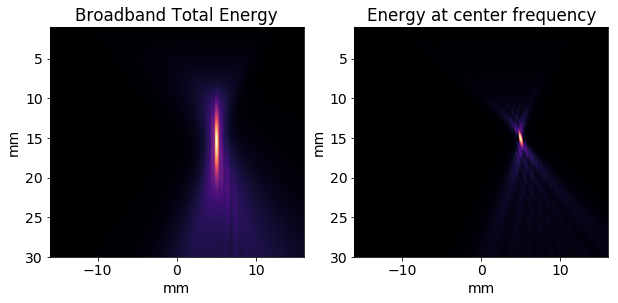

In [372]:
fi = np.argmin(np.abs(sampling_freqs-fc))

plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(np.sum( np.abs(prmf[0:])**2, axis=0).T, extent=imgBoundsT )
plt.title('Broadband Total Energy')
plt.xlabel('mm')
plt.ylabel('mm')

plt.subplot(122)
plt.imshow( np.abs(prmf[fi]).T**2, extent=imgBoundsT )
plt.title('Energy at center frequency')
plt.xlabel('mm')
plt.ylabel('mm')

In [373]:
#Inverse fft to get time-resolved pulse

prmf_vs_t = np.fft.ifft( prmf, axis=0)

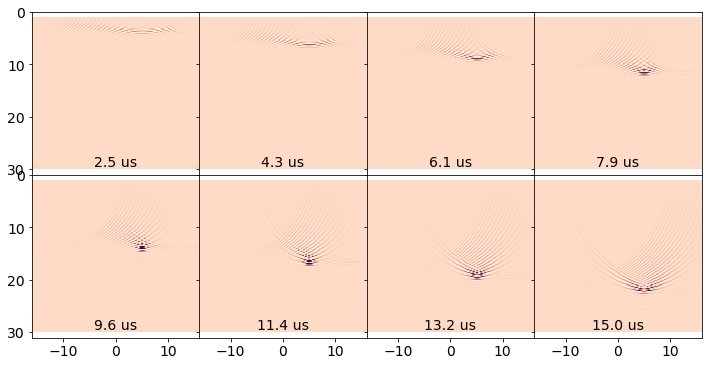

In [426]:
peak_pr = prmf_vs_t.real.max()

ncol = 4
nrows = 2

frames = np.linspace(50, 300, ncol*nrows,dtype=int)

fig,axs = plt.subplots(nrows,ncol, squeeze=True, sharex=True,sharey=True, gridspec_kw=dict(wspace=0, hspace=0), figsize=(12,6))

for i in range(len(axs.flat)):
    j = frames[i]
    plt.sca(axs.flat[i]) 
    plt.imshow(prmf_vs_t[j].real.T, vmin=-.5*peak_pr, vmax=.75*peak_pr, extent=imgBoundsT, cmap=plt.cm.RdBu )
    
    plt.text(0.5,0.05,'%0.1f us'% t_axis_us[j], color='k', transform=plt.gca().transAxes, ha='center' )
    
